In [55]:
from typing import Callable

import numpy as np
import pandas as pd
import pendulum
from dataclasses import dataclass
from loguru import logger
import matplotlib.pyplot as plt
import influxdb

In [58]:
# Define credentials for accessing InfluxDB
bucket = "mybucket"
org = "myorg"
token = "mytoken"
host="myhost.local"
port=8086
influxdb_url = "http://myhost.local:8086/"

In [60]:
# Establish and test DB connection
client = influxdb.InfluxDBClient(username=None, password=None, host=host, port=port, database=db_name, headers={"Authorization": f"Token {token}"})
version = client.ping()
print(version)

v2.7.1


In [61]:
@dataclass
class FullSKPath:
    source: str
    path: str

In [62]:
def circ_mean(alpha):
    return np.arctan2(np.sum(np.sin(alpha)), np.sum(np.cos(alpha)))


def angle_diff(alpha, beta, min=-np.pi):
    return (beta - alpha - min) % (2 * np.pi) + min


def circ_std(alpha, mean=None):
    if mean is None:
        mean = circ_mean(alpha)
    return np.sqrt((np.sum(angle_diff(mean, alpha) ** 2)) / len(alpha))


def aggregate_series(
    series: pd.Series,
    aggregate_funcs: list[str | Callable],
    names: list[str],
    window_period: str,
    smart=True,
) -> pd.DataFrame:
    """
    Aggregate a single path.

    Aggregate a single SK path using the `aggregate` function and the
    `window_period` time period.

    If `smart` is True, the function will try to infer from the series name
    whether the series data is circular or not.
    """
    circular_names = ["heading", "course", "bearing", "direction", "angle"]

    orig_name:str = series.name

    if smart:
        # try to infer whether the series is circular or not
        if any([name in orig_name.lower() for name in circular_names]):
            # if the series name contains any of the circular names, assume
            # it is circular
            circ_func_map = {
                "mean": circ_mean,
                "std": circ_std,
            }
            # replace the aggregate functions with the circular versions
            aggregate_funcs = [
                circ_func_map.get(func, func) for func in aggregate_funcs
            ]

    aggregates = series.resample(window_period).agg(aggregate_funcs)
    # append names to orig_name, separated with a dot
    aggregates.columns = [".".join([orig_name, name]) for name in names]

    return aggregates

In [63]:
class InfluxQuery:
    def __init__(self, client: influxdb.InfluxDBClient) -> None:
        self.client = client
        
    def query_raw(
        self,
        start_time: str,
        end_time: str,
        fullpath: FullSKPath,
    ) -> pd.Series:
        """
        Query a single path from the database.

        Query a single SK path from the InfluxDB database.
        The raw data is returned.

        Args:
            start_time: Start time of the query.
            end_time: End time of the query.
            fullpath: FullSKPath object containing the source and path.
        """

        if fullpath.source is None:
            tag_filter = ""
        else:
            tag_filter = f' AND ("source"::tag = "{fullpath.source}")'

        select_value_str = '"value"'

        ql_query = f"""
            SELECT {select_value_str} FROM "skdata-rp"."{fullpath.path}"
            WHERE (time >= '{start_time}') AND (time < '{end_time}') {tag_filter}
            """

        logger.debug(f"Querying {fullpath.path} from {start_time} to {end_time}")

        rs = self.client.query(ql_query)

        assert rs.error is None, f"Error in query: {rs.error}"

        ser = pd.Series(data=[p["value"] for p in rs.get_points()], index=pd.to_datetime([p["time"] for p in rs.get_points()], format="ISO8601"))
        ser.name = fullpath.path

        return ser

    def query_paths(self, start_time, end_time, fullpaths, window_period):
        """
        Query multiple paths from the database.

        Query multiple SK paths from the InfluxDB database. The paths are returned
        as a Pandas DataFrame, where each column is a path. The data is aggregated
        using the `aggregate` function and the `window_period` time period.
        """
        df_list = []
        for fullpath in fullpaths:
            path_ser = self.query_raw(start_time, end_time, fullpath)
            df_list.append(aggregate_series(path_ser, ["mean", "std"], ["mean", "std"], window_period,))
        df = pd.concat(df_list, axis=1)
        return df

    def query_split(
        self, start_time, end_time, fullpaths, window_period, days=2
    ):
        """
        Query multiple paths from the database, splitting the query into multiple
        queries over time.
        """
        dfs = []
        for dt in pendulum.period(start_time, end_time).range("days", days):
            end_ = dt.add(days=days)
            if end_ > end_time:
                end_ = end_time
            df = self.query_paths(
                dt, end_, fullpaths, window_period
            )
            dfs.append(df)
        df = pd.concat(dfs)
        return df


In [73]:
# Define start and end times of the analysis.
# Window period defines the time period over which the data is aggregated.
# Meaning that you should be sailing or steaming with a constant speed
# and constant direction for at least the window period to get one data point.

start_time = pendulum.parse("2023-07-05T00:00:00Z")
end_time = pendulum.parse("2023-08-02T00:00:00Z")
window_period = "1min"

In [74]:
# Analyze these paths for starters
variables = [
    FullSKPath(None, "navigation.speedThroughWater"),
    FullSKPath(None, "navigation.speedOverGround"),
    FullSKPath(None, "navigation.headingTrue"),
    FullSKPath(None, "navigation.courseOverGroundTrue"),
]

In [75]:
# Load the data from the DB. This takes a while. For convenience, the data is
# saved to a pickle file, so you don't have to load it again if you restart the
# notebook.

df = InfluxQuery(client).query_split(start_time, end_time, variables, "1min", days=1)
# save the data to a pickle file
df.to_pickle("data_cache.pickle")

# Comment out above and uncomment below to load from pickle file.

# load the data from the pickle file
#df = pd.read_pickle("data_cache.pickle")

2023-09-26 00:12:58.037 | DEBUG    | __main__:query_raw:35 - Querying navigation.speedThroughWater from 2023-07-05T00:00:00+00:00 to 2023-07-06T00:00:00+00:00
2023-09-26 00:12:59.396 | DEBUG    | __main__:query_raw:35 - Querying navigation.speedOverGround from 2023-07-05T00:00:00+00:00 to 2023-07-06T00:00:00+00:00
2023-09-26 00:13:03.358 | DEBUG    | __main__:query_raw:35 - Querying navigation.headingTrue from 2023-07-05T00:00:00+00:00 to 2023-07-06T00:00:00+00:00
2023-09-26 00:13:20.793 | DEBUG    | __main__:query_raw:35 - Querying navigation.courseOverGroundTrue from 2023-07-05T00:00:00+00:00 to 2023-07-06T00:00:00+00:00
/var/folders/5s/d9zl8w4n24d0dzjq87jpxwg40000gn/T/ipykernel_93004/1659276095.py:12: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt((np.sum(angle_diff(mean, alpha) ** 2)) / len(alpha))
2023-09-26 00:13:21.264 | DEBUG    | __main__:query_raw:35 - Querying navigation.speedThroughWater from 2023-07-06T00:00:00+00:00 to 2023-07-07T00:00:00+00:0

<Axes: >

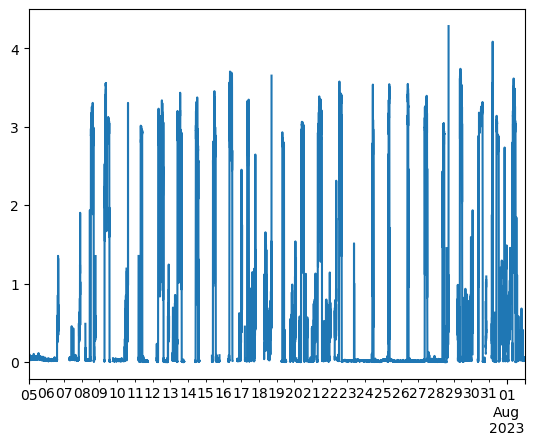

In [76]:
# Do some plotting to see if the data looks ok.
df["navigation.speedOverGround.mean"].plot()

In [78]:
# Define some convenience conversion functions.

def kn(x):
    return 3.6 / 1.852 * x


def celsius(x):
    return x - 273.15


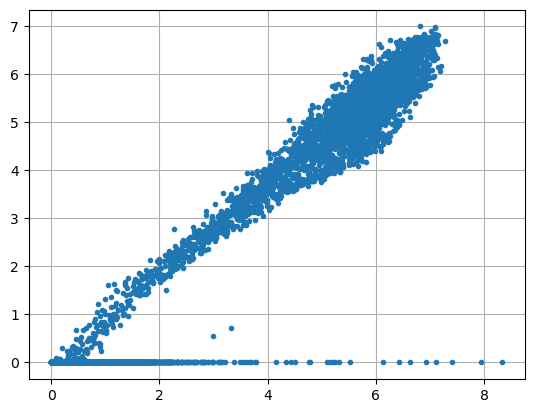

In [79]:
# Plot speed over ground vs speed through water. There are probably a lot of
# outliers in the data.
plt.figure()
plt.plot(
    kn(df["navigation.speedOverGround.mean"]), kn(df["navigation.speedThroughWater.mean"]), "."
)
plt.grid()

In [80]:
from sklearn import linear_model

In [81]:
dfs = df[
    [
        "navigation.speedThroughWater.mean",
        "navigation.speedOverGround.mean",
        "navigation.speedOverGround.std",
        "navigation.headingTrue.std",
    ]
]

In [82]:
dfn = dfs.dropna()

In [83]:
dfn.columns

Index(['navigation.speedThroughWater.mean', 'navigation.speedOverGround.mean',
       'navigation.speedOverGround.std', 'navigation.headingTrue.std'],
      dtype='object')

In [84]:
dfn0 = dfn[dfn["navigation.speedThroughWater.mean"] > 0.1]


In [85]:
np.any(dfn0["navigation.speedThroughWater.mean"] == 0)

False

In [86]:
dfn0.size


20224

<Axes: ylabel='Frequency'>

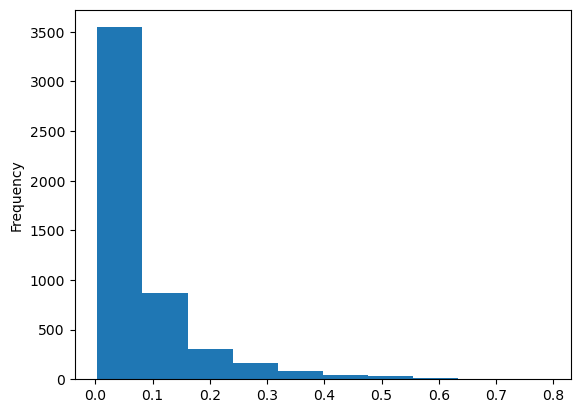

In [87]:
# Let's see what the standard deviation of the SOG looks like. Meaning,
# how constant the speed has been in each window period.

dfn0["navigation.speedOverGround.std"].plot.hist()


<Axes: ylabel='Frequency'>

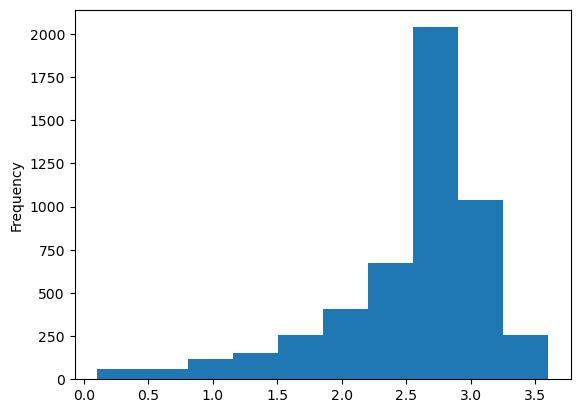

In [88]:
dfn0["navigation.speedThroughWater.mean"].plot.hist()


<Axes: ylabel='Frequency'>

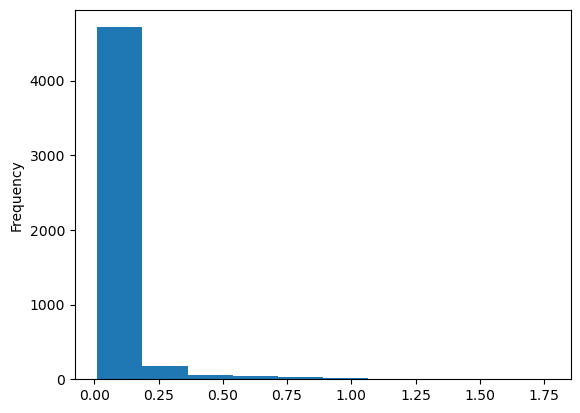

In [89]:
dfn0["navigation.headingTrue.std"].plot.hist()


In [90]:
# Let's filter out some outliers.

dfc = dfn0.loc[
    np.logical_and(
        dfn0["navigation.speedOverGround.std"] < 1,
        dfn0["navigation.headingTrue.std"] < 0.5,
    )
]


In [91]:
# STW is not accurate at speeds below 1.2 kn.

dfc = dfc[dfc['navigation.speedOverGround.mean']>1.2/1.944]

In [92]:
stw = dfc["navigation.speedThroughWater.mean"]
sog = dfc["navigation.speedOverGround.mean"]

(array([   4.,   53.,   95.,  141.,  287.,  388.,  869., 1882.,  923.,
         230.]),
 array([0.28084746, 0.61267938, 0.9445113 , 1.27634322, 1.60817514,
        1.94000706, 2.27183898, 2.6036709 , 2.93550282, 3.26733475,
        3.59916667]),
 <BarContainer object of 10 artists>)

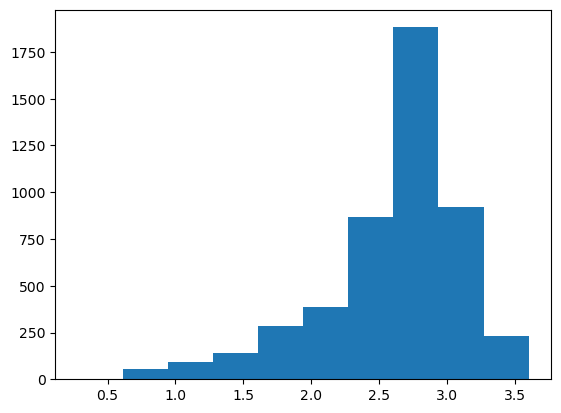

In [93]:
plt.hist(stw, bins=10)

In [94]:
# Pulse frequency vs STW (old). This should come from the 
# signalk-dst800-calibration plugin!
previous_calibration_table = np.array(
    [
        [2.32620295, 0.51444444],
        [7.86023356, 1.02888889],
        [17.91440332, 2.05777778],
        [26.61671779, 3.08666667],
        [33.96717696, 4.11555556],
        [44.61252943, 6.17333333],
        [47.90742273, 7.20222222],
        [49.85046074, 8.23111111],
    ]
)


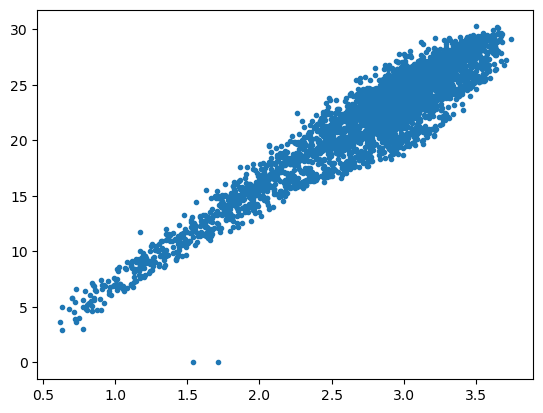

In [96]:
# Plot the data again, now as SOG vs pulse frequency.

def lambda_factory(ab):
    return lambda x: x * ab[0] + ab[1]


def broken_line(x, x0, y0):
    cl = []
    fl = []
    for i in range(len(x0) - 1):
        ab = np.polyfit(x0[i : i + 2], y0[i : i + 2], 1)
        # Compute and append a "condition" interval
        cl.append(np.logical_and(x >= x0[i], x <= x0[i + 1]))
        # Create a line function for the interval
        fl.append(lambda_factory(ab))
    return np.piecewise(x, condlist=cl, funclist=fl)


calib_table = previous_calibration_table
x0 = calib_table[:, 1]
y0 = calib_table[:, 0]

freq = broken_line(np.array(stw), x0, y0)

plt.plot(sog, freq, ".")

# r = np.array([row[0]/row[1] for row in factory_calibration_table])


In [97]:
X = np.array([sog, sog]).T
y = np.array(freq)

lm = linear_model.LinearRegression(fit_intercept=False)
model = lm.fit(X, y)


In [100]:
def get_X_matrix(vector):
    return np.concatenate((vector.reshape(-1, 1), vector.reshape(-1, 1)), axis=1)

Xvec = np.arange(0, 5, step=0.1)
Xp = get_X_matrix(Xvec)
yp = lm.predict(Xp)
lm.score(X, y)


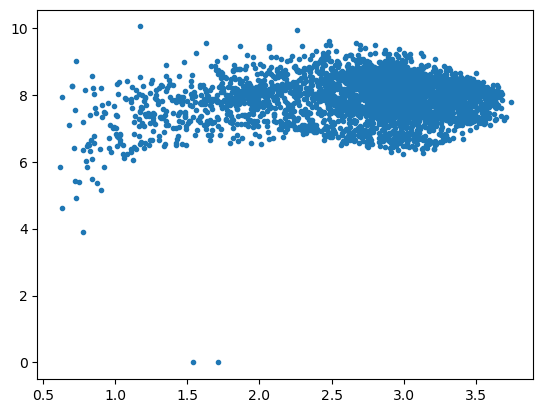

In [108]:
plt.figure()
plt.plot(sog, freq / sog, ".")


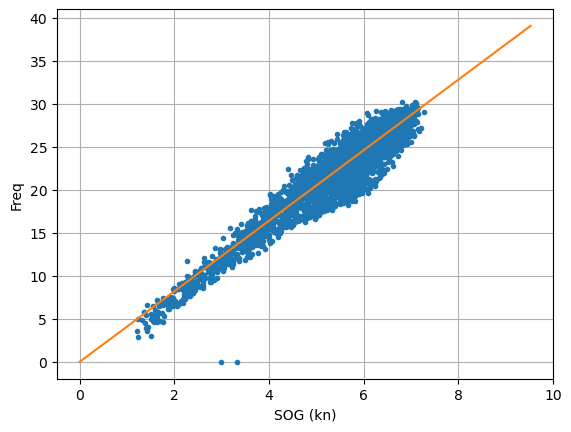

In [109]:
# Linear fit.

plt.figure()
plt.plot(kn(sog), freq, ".")
plt.plot(kn(Xvec), yp)
plt.xlabel("SOG (kn)")
plt.ylabel("Freq")
plt.grid()


In [110]:
p = np.polynomial.polynomial.Polynomial.fit(sog, freq, 2)


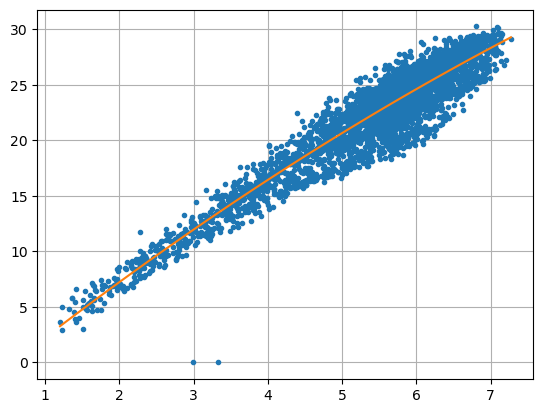

In [111]:
# Polynomial fit.

plt.figure()
plt.plot(kn(sog), freq, ".")
x, y = p.linspace()
plt.plot(kn(x), y)
plt.grid()


In [112]:
sogs = np.array([1, 2, 4, 5, 6, 7, 8, 10]) / kn(1)

# output an array of pulse rate and desired STW
out = np.array([p(sogs).T, sogs.T]).T
out

In [115]:
# Print out the updated calibration table.

print("Calibration table:")
for row in out:
    print(f"{row[0]:.2f} {row[1]:.2f}")



Calibration table:
2.23 0.51
7.23 1.03
16.44 2.06
20.66 2.57
24.62 3.09
28.33 3.60
31.77 4.12
37.88 5.14
